# Sarima Espanha

Neste notebook será aplicado o modelo Sarima, ou Arima considerando a sazonalidade, baseado neste artigo no medium (que pode ser acessado [aqui](https://towardsdatascience.com/time-series-forecasting-with-sarima-in-python-cda5b793977b)) que vai ser aplicado nos casos de morte por Covid na Espanha.

In [ ]:
# Importando as blibiotecas
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from itertools import product

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [ ]:
# Importando o dataset
url = 'https://raw.githubusercontent.com/aaasatoou/bootcamp_blue_Projeto2/main/datasets/serie%20temporal%20pais/S%C3%A9ries%20Temporais%20Espanha.csv'
serie_esp = pd.read_csv(url)
serie_esp.drop('Unnamed: 0',axis=1,inplace=True)
serie_esp['Date'] = pd.to_datetime(serie_esp['Date'],format='%Y-%m-%d')
serie_esp.set_index('Date',inplace=True)
serie_esp.head()

,Confirmed,Recovered,Deaths,Ano,Mês
Date,,,,,
2020-01-22,0,0.0,0,2020,1
2020-01-23,0,0.0,0,2020,1
2020-01-24,0,0.0,0,2020,1
2020-01-25,0,0.0,0,2020,1
2020-01-26,0,0.0,0,2020,1


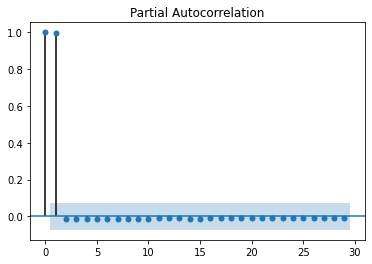

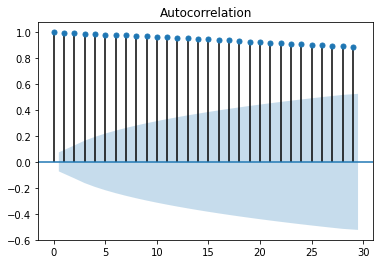

In [ ]:
plot_pacf(serie_esp['Deaths']);
plot_acf(serie_esp['Deaths']);

In [ ]:
ad_fuller_result = adfuller(serie_esp['Deaths'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.7321257366988643
p-value: 0.41464093842662825


In [ ]:
# Separação entre treino e teste
treino = serie_esp[(serie_esp['Ano']<=2021)&(serie_esp['Mês']<12)]
teste = serie_esp[(serie_esp['Ano']==2021)&(serie_esp['Mês'] == 12)]

In [ ]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [ ]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, treino['Deaths'])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(1, 1, 0, 1)",9115.643532
1,"(3, 1, 0, 1)",9116.682356
2,"(1, 3, 0, 1)",9116.774902
3,"(1, 1, 0, 3)",9117.097795
4,"(1, 2, 0, 1)",9117.363247
...,...,...
244,"(3, 0, 0, 0)",9458.479653
245,"(0, 1, 0, 0)",9469.279104
246,"(1, 0, 0, 0)",9469.667927
247,"(2, 0, 0, 0)",9469.808305


In [ ]:
best_model = SARIMAX(treino['Deaths'], order=(1, 1, 1), seasonal_order=(1, 2, 1, 4)).fit(dis=-1)
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                            Deaths   No. Observations:                  648
Model:             SARIMAX(1, 1, 1)x(1, 2, 1, 4)   Log Likelihood               -4625.829
Date:                           Thu, 15 Dec 2022   AIC                           9261.657
Time:                                   23:53:44   BIC                           9283.957
Sample:                                        0   HQIC                          9270.314
                                           - 648                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9997    135.717     -0.007      0.994    -267.001     265.001
ma.L1          0.9998    164.645      0.006

In [ ]:
fc = best_model.forecast(31, alpha=0.05)

In [ ]:
fc

648    88069.057647
649    88088.120832
650    88128.572661
651    88162.949830
652    88171.609607
653    88181.286314
654    88228.408710
655    88267.931932
656    88280.885050
657    88295.359264
658    88339.570451
659    88376.876490
660    88387.795564
661    88399.995657
662    88446.072767
663    88484.832669
664    88496.872306
665    88510.323939
666    88555.885265
667    88594.268777
668    88605.856204
669    88618.801608
670    88665.034583
671    88703.954204
672    88715.873549
673    88729.189086
674    88775.501698
675    88814.502490
676    88826.362814
677    88839.611561
678    88886.298966
Name: predicted_mean, dtype: float64

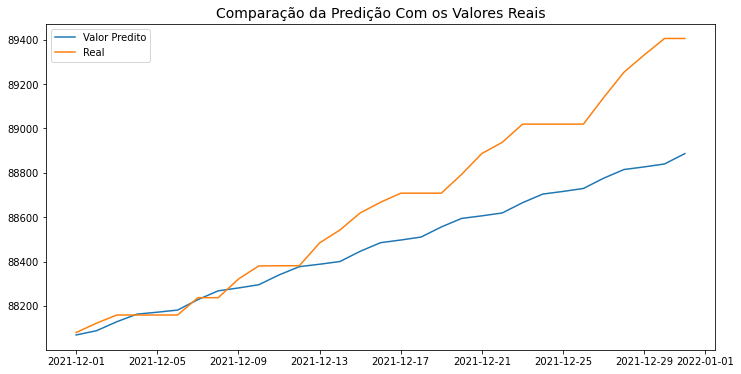

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Comparação da Predição Com os Valores Reais', fontsize=14)
plt.plot(teste.index,fc,label='Valor Predito')
plt.plot(teste.index,teste['Deaths'].values,label='Real')
plt.legend()

In [ ]:
print('MAPE:',mean_absolute_percentage_error(teste['Deaths'],fc))
print('MAE:',mean_absolute_error(teste['Deaths'],fc))
print('RMSE:',np.sqrt(mean_squared_error(teste['Deaths'],fc)))

MAPE: 0.0021487221202456004
MAE: 191.2546087534565
RMSE: 254.10773506624687
